## Geneva Dataset Task Suitability and Exploration
**_Exploration of the dataset and Few-Shot approaches_**

I think that the Geneva satellite dataset can be suitable for few-shot segmentation, but it wasn't originally designed for this purpose, and might need some adjustment. Conceptually, I think that a better dataset for task should be bigger, and multi-city. Anyways, maybe the task still work perfectly fine also with this dataset. Below my intuition of why this is the case.

#### Dataset facts:

- It has 1,050 labeled image-mask pairs, which is enough to simulate few-shot scenarios  
- Three distinct categories (all/industrial/residential) let you create meaningful support/query splits  
- Data (images) are geolocated (we have latitude and longitude in the file's name; i.e., "DOP25_LV03_{grid}_{year}_1_15_{x_coord}_{y_coord}.png")
- There is a "Grid" reference as well, but it's not exactly clear what it is (i,e., 1301_11, 1301_13, 1301_31). It should define different part of Geneva, but not clear
- We have labels (pixel-level mask for segmentation) for all the images (we will pretend we don't for the few-shot task)
- The segmentation task is well-defined: rooftop vs background is a clear binary problem  
- Real-world policy relevance: solar panel installation assessment is a concrete government use case

#### What needs to be adapted

- The current 840-train/104-val/106-test split assumes traditional supervised learning
- Need some refinement for few-shot learning to work; but first, what few-shot learning? 

#### Conceptualization of Few-Shot Task

Two approaches:  
1. Few-Shot Fine-Tuning for Domain Adaptation &rarr; we have a pre-trained model for segmentation that we can fine tune using the labelled data that we have; imagine have other unlabelled data form e.g. different neighbourhood, city, or source. The organization has no capacity to label data, and needs a fast way to adapt the pre-trained model to a new domain &rarr; **few-shot fine tuning for domain adaptation is a good solution** if we only use this dataset.
2. Few-Shot Meta-Learning &rarr; standard meta-learning approach where the model learns "how to learn from few examples" &rarr; model learns to use support set features to segment query images &rarr; this would be useful if we need different segmentation problems in different domain &rarr; e.g. we have to deploy to 50 cities or from various satellite sources or in different climate/architectonical conditions (e.g. mountain area vs maritime area).

If Few-Shot Meta-Learning is really cool, and works well for adaptation under different domains. However, if we do this, this dataset is not well-suited, and for this dataset, Few-Shot Fine-Tuning is better. Moreover, the first option might still be very useful for organizations.

#### Geneva Dataset and Few-Shot Fine-Tuning for Domain Adaptation

- In the dataset, images are already divided into 'residential' and 'industrial' types. The simplest idea is to use a pre-trained model to segment rooftops of residential building, and use few-shot fine-tuning to adapt the model to segment industrial building (with only 3-5 labels). This is an easy task, and can be used as sandbox example. 

- A more complex scenario is to use a pre-trained model to segment rooftops of a specific area of Geneva (we have coordinates for each image, so even if we don't have a geographical variable we can easily create it, or we can use different grid sections) and use few-shot fine-tuning to adapt the model to segment rooftops of another area, that looks different (we can choose looking at satellite images if working with grid sections is unsuitable). Different parts of the city likely have different characteristics: urban density, building ages, roof types. We would simulate this "scaling to another city" by working at neighbourhood/area level.

#### Few-Shot Learning with this specific dataset

In our dataset, labels exist for every image, but we can pretend they don't during the few-shot phase. The setup would work like this:

**Training Phase (Base Model):**

- Use the full training set (840 images + labels) to learn general rooftop segmentation features &rarr; foundation model

**Few-Shot Evaluation Phase:**

- Randomly select K images from the test set as your "support set" (e.g., K=5 for 5-shot) &rarr; these are the only labels we allow the model to use for adaptation
- Test on the remaining images as "query set"
- The remaining labels are used only for evaluation

We would simulate the scenario in which we explore the question: "We deployed our model to a new city/building type, but we only have budget to label 5 examples. Can we still segment rooftops accurately?"

#### We can include Active Learning 

How to strategically select which 5-10 images to label (the most informative examples), random that labelling randomly?
Two appraoches:

1. Use base model uncertainty to select the most informative K examples (calculate uncertainty with entropy) &rarr; the easiest and probabily most effective for the tutorial
2. Extract features from all target images and select the most diverse using clustering or maximum distance selection (?) 
3. Use both (uncertainy and diverstiy)

#### Potential Structure of the Tutorial

**Part 1: Proof of Concept (Residential → Industrial)**  
Goal: Show that few-shot adaptation works at all

Setup:

Train base model on residential images (221 images)
Few-shot adapt using K={1, 3, 5, 10} industrial examples
Test on remaining industrial images

Comparisons to make it convincing:

- Baseline 1: Base model (trained on residential) tested directly on industrial with zero adaptation &rarr; shows the domain gap
- Baseline 2: Train from scratch on K industrial examples &rarr; shows you need pre-training
Approach: Pre-train on residential + fine-tune on K industrial examples &rarr; shows few-shot works
Upper bound: Train on all industrial data &rarr; shows how close you get to "full supervision"

This validates the core concept.

**Part 2: Geographic Transfer (More Realistic)**  
Goal: Show it works for the actual government use case

Setup:

Split data by geographic grid coordinates (1301_11, 1301_13, 1301_31)
Train on grids A, few-shot adapt to grid B+C with K examples
This simulates mapping to another neighbourhood or city.

**Part 3: Active Learning**  
How to integrate active learning for smarter selection of images to be labelled.

**Part 4: Analysis & Insights**  
Show:

- How performance scales with K (plot accuracy vs number of shots)
- Which K is "good enough" for deployment (cost-benefit analysis)
- Visualize predictions: show where few-shot model succeeds/fails

#### Exploration of the dataset

In [2]:
from huggingface_hub import snapshot_download
from PIL import Image
import torch
from torchvision import transforms

# Download the entire dataset
dataset_path = snapshot_download(
    repo_id="raphaelattias/overfitteam-geneva-satellite-images",
    repo_type="dataset"
)

print(f"Dataset downloaded to: {dataset_path}")

/Users/giocopp/miniconda3/envs/DL-Tutorial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching ... files: 2111it [00:00, 120594.59it/s]

Dataset downloaded to: /Users/giocopp/.cache/huggingface/hub/datasets--raphaelattias--overfitteam-geneva-satellite-images/snapshots/3f90d759384e4cd38276290521b6f6b03ddfcf87


In [3]:
from PIL import Image
import os

# After downloading, load image and label
train_img_path = os.path.join(dataset_path, "train/images/all/DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5.png")
train_label_path = os.path.join(dataset_path, "train/labels/all/DOP25_LV03_1301_11_2015_1_15_497500.0_119062.5_label.png")

image = Image.open(train_img_path)
label = Image.open(train_label_path)


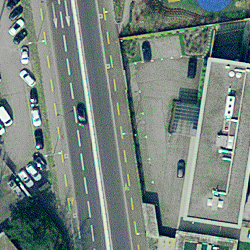

In [4]:
image

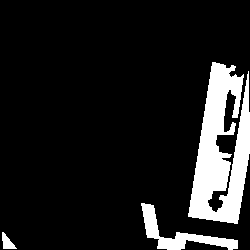

In [5]:
label

In [6]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from huggingface_hub import snapshot_download
from PIL import Image
import os

class GenevaRooftopDataset(Dataset):
    def __init__(self, split='train', category='all', transform=None, dataset_path=None):
        """
        Args:
            split (str): One of 'train', 'val', or 'test'
            category (str): One of 'all', 'industrial', or 'residencial'
            transform: Optional transform to be applied on images and labels
            dataset_path (str): Path to downloaded dataset. If None, will download automatically.
        """
        if dataset_path is None:
            dataset_path = snapshot_download(
                repo_id="raphaelattias/overfitteam-geneva-satellite-images",
                repo_type="dataset"
            )

        self.split = split
        self.category = category
        self.image_dir = os.path.join(dataset_path, f"{split}/images/{category}")
        self.label_dir = os.path.join(dataset_path, f"{split}/labels/{category}")
        self.transform = transform

        self.images = sorted([f for f in os.listdir(self.image_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        label_name = img_name.replace('.png', '_label.png')

        image = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, label_name))

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

# Create dataset - will automatically download if needed
train_dataset = GenevaRooftopDataset(split='train', category='all')
val_dataset = GenevaRooftopDataset(split='val', category='all')
test_dataset = GenevaRooftopDataset(split='test', category='all')

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Fetching ... files: 2111it [00:00, 135364.25it/s]
Fetching ... files: 2111it [00:00, 141032.73it/s]
Fetching ... files: 2111it [00:00, 113850.79it/s]

Train samples: 420
Val samples: 52
Test samples: 53


Tomorrow: continue